### Fine-Tuning Summarization Model(Pegasus)on Custom Dataset

### Dependency Installation

In [2]:
!pip install transformers[sentencepiece] transformers[torch] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 

In [1]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

### Download Model

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load Dataset

In [3]:
from datasets import load_dataset

samsum = load_dataset('samsum')
samsum

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

### Visualize length

In [4]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

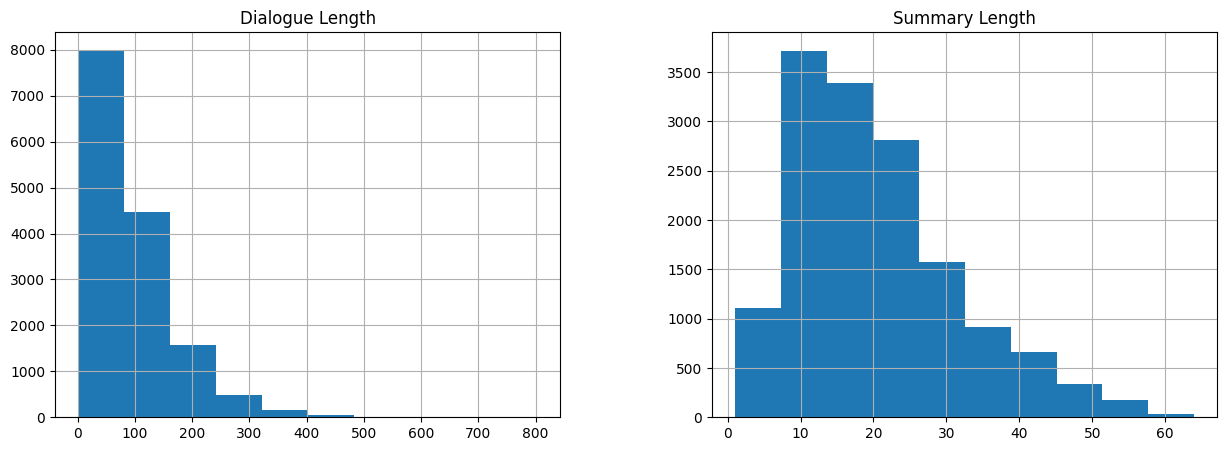

In [5]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

In [6]:
def preprocess_function(example_batch):

    encodings = tokenizer(example_batch['dialogue'], text_target=example_batch['summary'],
                        max_length=1024, truncation=True)

    encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

    return encodings

With preprocess_function(), it is then a simple matter to tokenize the whole corpus using the handy Dataset.map() function

In [7]:
samsum_tokenize_pt = samsum.map(preprocess_function, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [8]:
columns = ['input_ids', 'labels', 'attention_mask']
samsum_tokenize_pt.set_format(type='torch', columns=columns)

Transformers provides a DataCollatorForSeq2Seq collator that will dynamically pad the inputs and the labels for us. To instantiate this collator, we simply need to provide the tokenizer and model:

In [9]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

### Build Trainer

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'pegasus-samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

In [11]:
trainer = Trainer(model=model_pegasus, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_tokenize_pt['train'], eval_dataset = samsum_tokenize_pt['validation'])


In [12]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.659900,1.483296


TrainOutput(global_step=920, training_loss=1.8251974468645842, metrics={'train_runtime': 2679.0162, 'train_samples_per_second': 5.499, 'train_steps_per_second': 0.343, 'total_flos': 5528248038285312.0, 'train_loss': 1.8251974468645842, 'epoch': 0.9991854466467553})

In [13]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [14]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

### Test Model

In [15]:
sample_text = samsum["test"][0]["dialogue"]

reference = samsum["test"][0]["summary"]

In [16]:
from transformers import pipeline

gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

In [17]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [18]:
custom_dialogue="""
Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Juli will give Tom a new project once he's back from a business trip. Tom did excellent in last quarter. Juli will assign new project once he's back.


### Calculate Rouge Score

In [19]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [20]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score


In [21]:
import nltk
from nltk.tokenize import sent_tokenize
from datasets import load_metric

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(
    samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary')

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = [f'pegasus'] )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 410/410 [13:09<00:00,  1.93s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018448,0.000341,0.018294,0.018353
